# VisiumHD tutorial

In [1]:
import sys
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch

import sys
from importlib import reload

import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit, restrict_spots, model_selection
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts, parse_adata
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

import seaborn as sns
import math

/local_home/uchitra/miniforge3/envs/gaston-package-v2/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/local_home/uchitra/miniforge3/envs/gaston-package-v2/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/local_home/uchitra/miniforge3/envs/gaston-package-v2/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.r

## Step 1: Pre-processing and dimensionality reduction

Here, GASTON takes as input the output of Space Ranger contained in the folder Visium_p1.
These files are in the following folder: https://drive.google.com/drive/u/1/folders/1GiibZwhpzlur8C1hNHa1g7I4jsc1Gmn7

In [2]:
!mkdir -p visium_github_issue_tutorial_data

First we will load the data from an adata object. 

In [2]:
data_folder='/local_home/uchitra/Visium_p1' # folder with filtered_feature_bc_matrix.h5ad
spot_umi_threshold=0 # filter out cells with low UMIs
folder_to_save='visium_github_issue_tutorial_data' # NAME OF FOLDER TO SAVE DATA

########################################################

adata=sq.read.visium(data_folder)
sc.pp.filter_cells(adata, min_counts=spot_umi_threshold)
adata.obsm["spatial"] = np.asarray(adata.obsm["spatial"], dtype=float)

gene_labels=adata.var.index.to_numpy()
counts_mat=np.array(adata.X.todense())
coords_mat=np.copy(adata.obsm["spatial"])
coords_mat[:,1] *= -1

# make sure counts_mat is NxG and coords_mat is Nx2
if counts_mat.shape[0] != coords_mat.shape[0]:
    counts_mat=counts_mat.T

# save matrices
np.save(f'{folder_to_save}/counts_mat.npy', counts_mat)
np.save(f'{folder_to_save}/coords_mat.npy', coords_mat)
np.save(f'{folder_to_save}/gene_labels.npy', gene_labels)

Visualize total UMI count

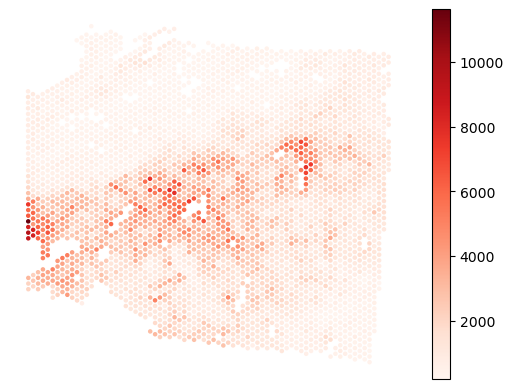

In [4]:
# visualize 
plt.scatter(coords_mat[:,0], coords_mat[:,1], c=counts_mat.sum(axis=1), cmap='Reds',s=5)
plt.axis('off')
plt.colorbar()

In [5]:
# should be NxG, Nx2, Gx3
counts_mat.shape, coords_mat.shape, gene_labels.shape

((3530, 17893), (3530, 2), (17893,))

Visualize gene

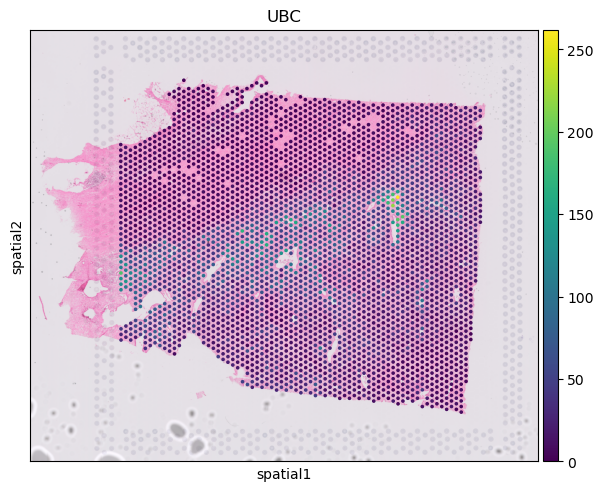

In [6]:
sq.pl.spatial_scatter(
    adata,
    color="UBC",           # Replace with your gene of interest
)

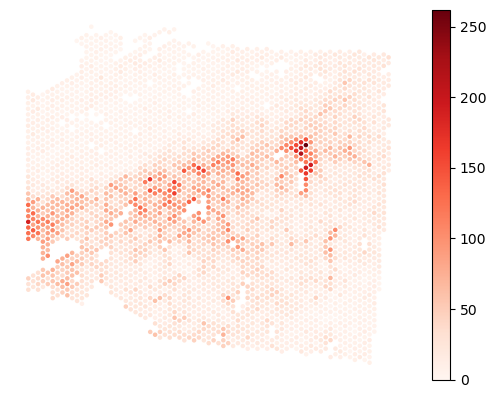

In [7]:
# visualize data
plt.scatter(coords_mat[:,0], coords_mat[:,1], c=counts_mat[:,8760], cmap='Reds',s=5)
plt.axis('off')
plt.colorbar()

## Option 1: compute GLM-PCs

We use 8 GLM-PCs.

In [10]:
# GLM-PCA parameters
num_dims=8
penalty=100 # may need to increase if this is too small

# CHANGE THESE PARAMETERS TO REDUCE RUNTIME
num_iters=30
eps=1e-4
num_genes=5000

counts_mat_glmpca=counts_mat[:,np.argsort(np.sum(counts_mat, axis=0))[-num_genes:]]
glmpca_res=glmpca.glmpca(counts_mat_glmpca.T, num_dims, fam="poi", penalty=penalty, verbose=True,
                        ctl = {"maxIter":num_iters, "eps":eps, "optimizeTheta":True})
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

np.save(f'{folder_to_save}/glmpca.npy', A)

Iteration: 0 | deviance=1.0436E+7
Iteration: 1 | deviance=1.0436E+7
Iteration: 2 | deviance=1.0436E+7
Iteration: 3 | deviance=1.0387E+7
Iteration: 4 | deviance=1.0158E+7
Iteration: 5 | deviance=1.0026E+7
Iteration: 6 | deviance=9.9791E+6
Iteration: 7 | deviance=9.9607E+6
Iteration: 8 | deviance=9.9523E+6
Iteration: 9 | deviance=9.9482E+6
Iteration: 10 | deviance=9.9458E+6
Iteration: 11 | deviance=9.9442E+6
Iteration: 12 | deviance=9.9429E+6


FileNotFoundError: [Errno 2] No such file or directory: 'visium_github_issue_tutorial_outputs/glmpca.npy'

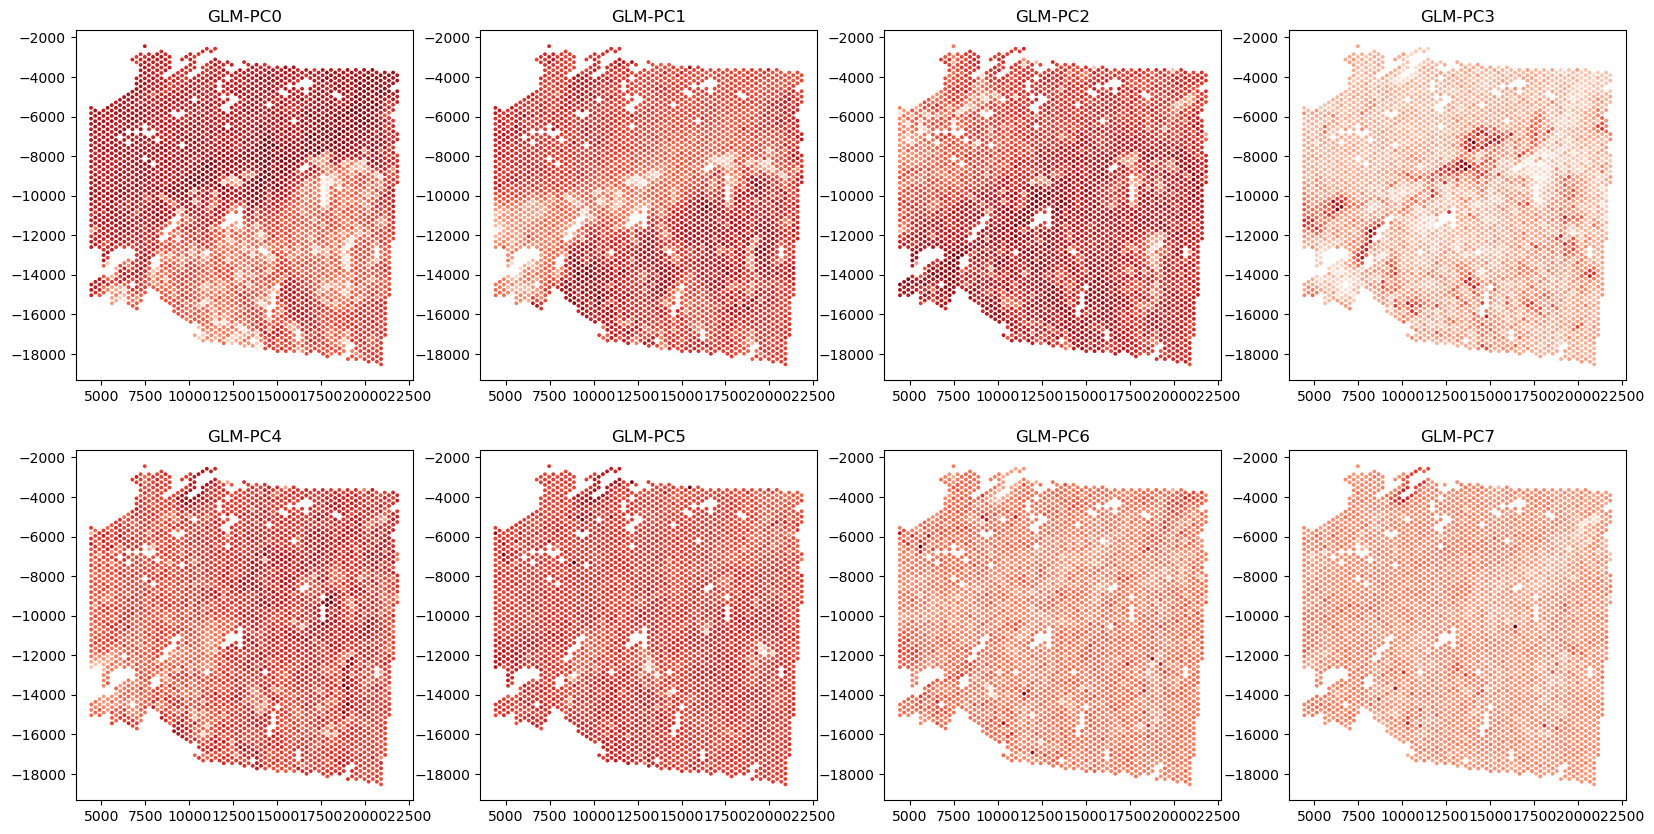

In [13]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'GLM-PC{i}')

## Option 2: use PCs of analytic Pearson residuals

In [4]:
num_dims=8
clip=0.01 # have to clip values to be very small!

A = parse_adata.get_top_pearson_residuals(num_dims,counts_mat,coords_mat,clip=clip)

np.save(f'{folder_to_save}/analytic_pearson.npy', A)

/local_home/uchitra/miniforge3/envs/gaston-package-v2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/local_home/uchitra/miniforge3/envs/gaston-package-v2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/local_home/uchitra/GASTON/src/gaston/parse_adata.py:33: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  adata.layers["raw"] = adata.X.copy()


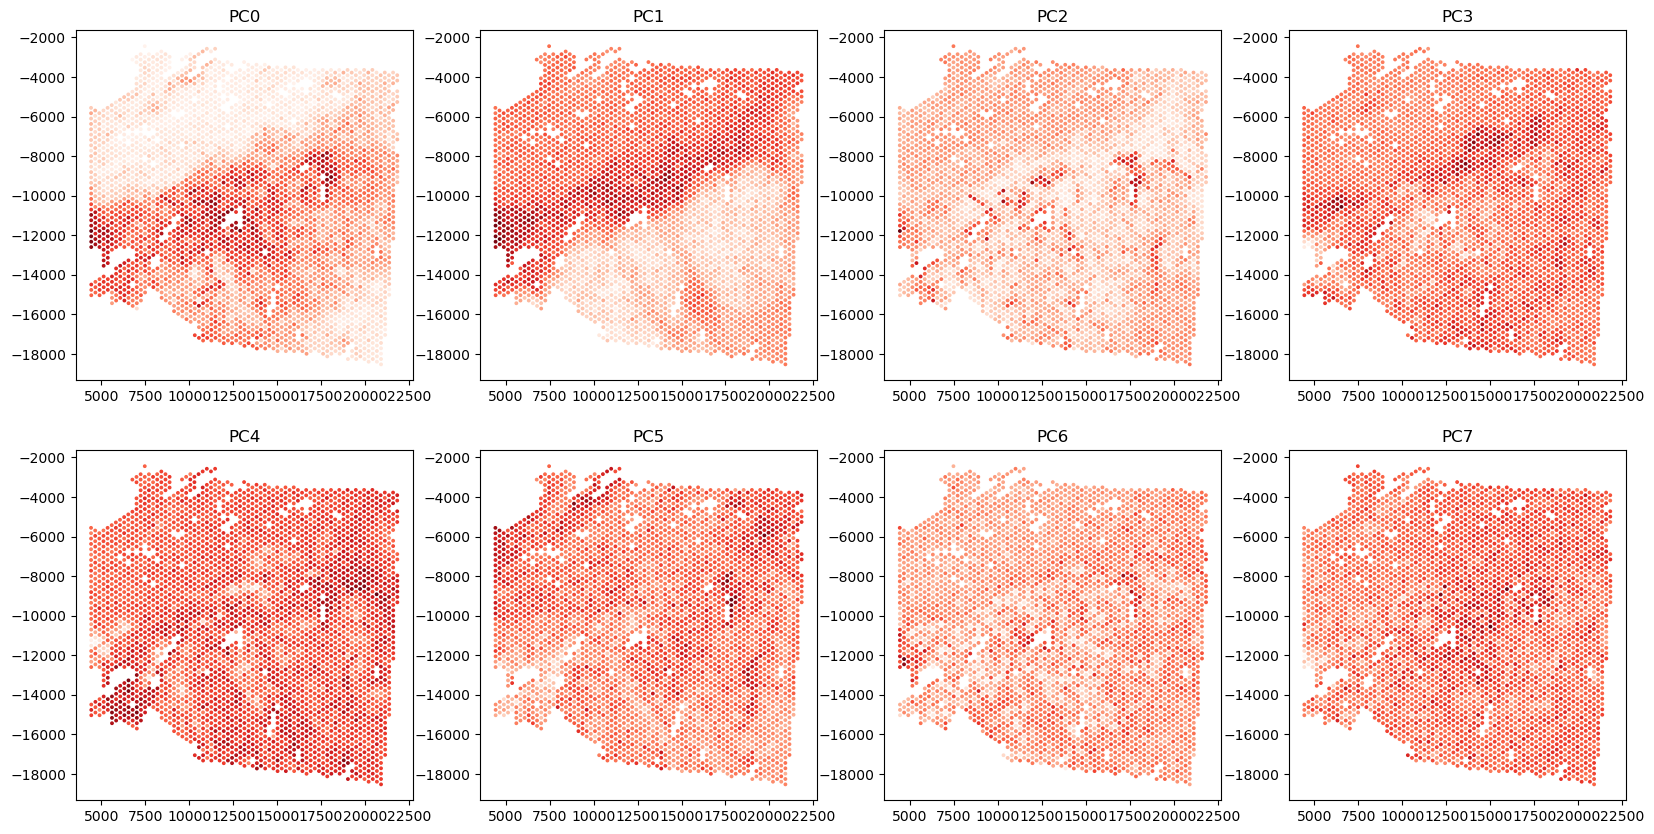

In [5]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'PC{i}')

## Step 2: Train GASTON neural network

We include how to train the neural network with two options: (1) a command line script and (2) in a notebook. We typically train the neural network 30 different times, each with a different seed, and we use the NN with lowest loss. 

### Option 1: Slurm

For option (1), the code below creates 30 different Slurm jobs, one for each initialization. To train the NN for a single initialization run the following command:

`gaston -i /path/to/coords.npy -o /path/to/glmpca.npy -d /path/to/output_dir -e 10000 -c 500 -p 20 20 -x 20 20 -z adam -s SEED`

for a given `SEED` value (integer)

NOTE: please wait for models to finish training before running below code. You can check on their status by running `squeue -u uchitra` (replacing `uchitra` with your username)

In [2]:
# LOAD DATA generated above
path_to_glmpca='visium_github_issue_tutorial_data/glmpca.npy'
# path_to_glmpca='visium_github_issue_tutorial_data/analytic_pearson.npy' # for the PCs from above
path_to_coords='visium_github_issue_tutorial_data/coords_mat.npy'

# GASTON NN parameters
isodepth_arch=[20,20] # architecture (two hidden layers of size 20) for isodepth neural network d(x,y)
expression_arch=[20,20] # architecture (two hidden layers of size 20) for 1-D expression function
epochs = 10000 # number of epochs to train NN
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
optimizer = "adam"
num_restarts=30 # number of initializations

time_to_train="0-01:00:00" # max amount of time to let the NN train - 1 hour. can set higher. 

output_dir='visium_github_issue_tutorial_outputs' # folder to save model runs

# REPLACE with your own conda environment name and path
conda_environment='gaston-package'
path_to_conda_folder='/n/fs/ragr-data/users/uchitra/miniconda3/bin/activate'

run_slurm_scripts.train_NN_parallel(path_to_coords, path_to_glmpca, isodepth_arch, expression_arch, 
                      output_dir, conda_environment, path_to_conda_folder,
                      epochs=epochs, checkpoint=checkpoint, 
                      num_seeds=num_restarts,time=time_to_train)

jobId: 19671909
jobId: 19671910
jobId: 19671911
jobId: 19671912
jobId: 19671913
jobId: 19671914
jobId: 19671915
jobId: 19671916
jobId: 19671917
jobId: 19671918
jobId: 19671919
jobId: 19671920
jobId: 19671921
jobId: 19671922
jobId: 19671923
jobId: 19671924
jobId: 19671925
jobId: 19671926
jobId: 19671927
jobId: 19671928
jobId: 19671929
jobId: 19671930
jobId: 19671931
jobId: 19671932
jobId: 19671933
jobId: 19671934
jobId: 19671935
jobId: 19671936
jobId: 19671937
jobId: 19671938


### Option 2: train in notebook

In [6]:
path_to_glmpca='visium_github_issue_tutorial_data/glmpca.npy'
# path_to_glmpca='visium_github_issue_tutorial_data/analytic_pearson.npy' # for the PCs from above
path_to_coords='visium_github_issue_tutorial_data/coords_mat.npy'

A=np.load(path_to_glmpca) # GLM-PCA results used in manuscript
S=np.load(path_to_coords)

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

In [7]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='visium_github_issue_tutorial_outputs' # folder to save model runs
optimizer = "adam"
num_restarts=30
device='cuda' # change to 'cpu' if you don't have a GPU

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, device=device,
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

training neural network for seed 0
Training on device: cuda
epoch: 0
epoch: 500
epoch: 1000
epoch: 1500
epoch: 2000
epoch: 2500
epoch: 3000
epoch: 3500
epoch: 4000
epoch: 4500
epoch: 5000
epoch: 5500
epoch: 6000
epoch: 6500
epoch: 7000
epoch: 7500
epoch: 8000
epoch: 8500
epoch: 9000
epoch: 9500
training neural network for seed 1
Training on device: cuda
epoch: 0
epoch: 500
epoch: 1000
epoch: 1500
epoch: 2000
epoch: 2500
epoch: 3000
epoch: 3500
epoch: 4000
epoch: 4500
epoch: 5000
epoch: 5500
epoch: 6000
epoch: 6500
epoch: 7000
epoch: 7500
epoch: 8000
epoch: 8500
epoch: 9000
epoch: 9500
training neural network for seed 2
Training on device: cuda
epoch: 0
epoch: 500
epoch: 1000
epoch: 1500
epoch: 2000
epoch: 2500
epoch: 3000
epoch: 3500
epoch: 4000
epoch: 4500
epoch: 5000
epoch: 5500
epoch: 6000
epoch: 6500
epoch: 7000
epoch: 7500
epoch: 8000
epoch: 8500
epoch: 9000
epoch: 9500
training neural network for seed 3
Training on device: cuda
epoch: 0
epoch: 500
epoch: 1000
epoch: 1500
epoch: 2

## Step 3: Process neural network output

In [8]:
gaston_model, A, S= process_NN_output.process_files('visium_github_issue_tutorial_outputs') # model trained above

# May need to re-load counts_mat, coords_mat, and gene_labels
counts_mat=np.load('visium_github_issue_tutorial_data/counts_mat.npy',allow_pickle=True) # download from google drive folder
coords_mat=np.load('visium_github_issue_tutorial_data/coords_mat.npy',allow_pickle=True)
gene_labels=np.load('visium_github_issue_tutorial_data/gene_labels.npy',allow_pickle=True)

/local_home/uchitra/GASTON/src/gaston/process_NN_output.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  St=torch.load(os.path.join(folder_path, 'Storch.pt'))
/local_hom


best model: visium_github_issue_tutorial_outputs/rep14


/local_home/uchitra/GASTON/src/gaston/process_NN_output.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  A_torch = torch.load(atorch_path)
/local_home/uchitra/GASTON/sr

**Model selection** for choosing number of domains

Kneedle number of domains: 5


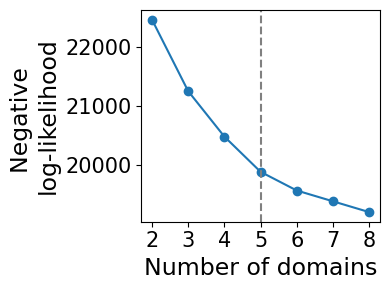

In [9]:
model_selection.plot_ll_curve(gaston_model, A, S, max_domain_num=8, start_from=2,num_buckets=100)

Compute isodepth and GASTON domains 

In [13]:
# 5 seems like too many layers so I changed to 3
num_layers=3
gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(gaston_model,A,S,num_layers)

Plot topographic map: isodepth and spatial gradients

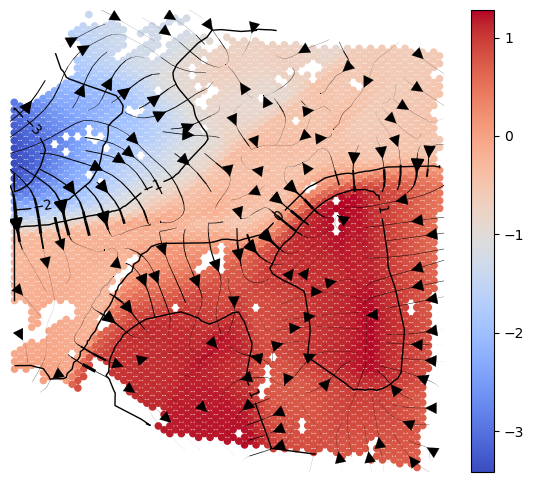

In [14]:
show_streamlines=True
arrowsize=2

cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, figsize=(7,6), streamlines=show_streamlines, 
                               arrowsize=arrowsize)

Plot GASTON domains

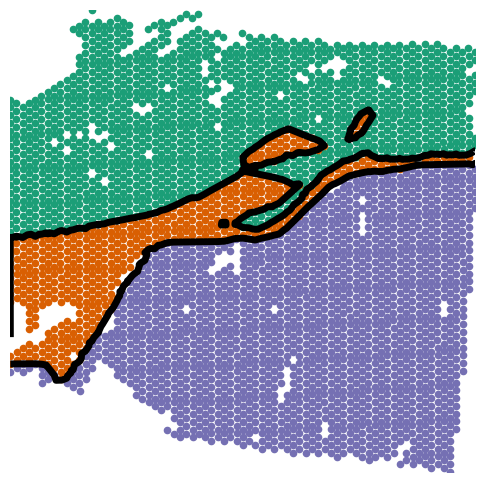

In [15]:
# domain_colors=colors=['plum', 'cadetblue', '#F3D9DC','dodgerblue', '#F44E3F']
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), s=20, lgd=False, 
                               show_boundary=True, gaston_isodepth=gaston_isodepth, boundary_lw=5)

## Continuous gradient analysis

### Compute piecewise linear fits

We restrict to genes with at least 1000 total UMIs, that are not mitochondrial/ribosomal

In [19]:
umi_thresh = 2000 # only analyze genes with at least 2000 total UMIs
idx_kept, gene_labels_idx=filter_genes.filter_genes(counts_mat, gene_labels, 
                                       umi_threshold=umi_thresh, 
                                       exclude_prefix=['MT-', 'RPL', 'RPS'])
print(f'{len(idx_kept)} genes kept')

328 genes kept


Compute piecewise linear fit over restricted spots from above

In [20]:
# compute piecewise linear fit for restricted spots
pw_fit_dict=segmented_fit.pw_linear_fit(counts_mat, gaston_labels, gaston_isodepth,
                                        None, [],  idx_kept=idx_kept, umi_threshold=umi_thresh)
# for plotting
binning_output=binning_and_plotting.bin_data(counts_mat, gaston_labels, gaston_isodepth, 
                         None, gene_labels, idx_kept=idx_kept, num_bins=15, umi_threshold=umi_thresh)

Poisson regression for ALL cell types


100%|██████████| 328/328 [10:13<00:00,  1.87s/it]


### Plot discontinuous and continuous genes

In [21]:
discont_genes_layer=spatial_gene_classification.get_discont_genes(pw_fit_dict, binning_output,q=0.95)
cont_genes_layer=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,q=0.8)

In [24]:
discont_genes_layer

defaultdict(list,
            {'C1QB': [1],
             'LAPTM5': [0],
             'ELF3': [1],
             'IGKC': [0, 1],
             'C7': [0, 1],
             'HLA-DPA1': [0],
             'HLA-DPB1': [1],
             'FOXO3': [0],
             'GPNMB': [0, 1],
             'PTGDS': [0, 1],
             'DEPP1': [0],
             'CTSD': [0, 1],
             'NR4A1': [1],
             'KRT8': [1],
             'OLFM4': [0],
             'FOS': [1],
             'IGHG1': [0, 1],
             'IGHM': [0],
             'TYROBP': [0, 1],
             'APOE': [0, 1],
             'FTL': [0, 1],
             'IGLC1': [0, 1],
             'INS': [0, 1]})

In [22]:
cont_genes_layer

defaultdict(list,
            {'CCNL2': [0],
             'NBL1': [2],
             'C1QB': [0, 1],
             'LAPTM5': [1],
             'COL16A1': [0],
             'JUN': [0, 1],
             'CCN1': [1, 2],
             'COL11A1': [0, 2],
             'S100A6': [1],
             'S100A4': [0],
             'MUC1': [0, 1],
             'TAGLN2': [1],
             'ATP1B1': [1],
             'GLUL': [1],
             'ELF3': [1],
             'GUK1': [1],
             'LBH': [0],
             'CRIM1': [0, 1],
             'ANTXR1': [0, 2],
             'IGKC': [0, 2],
             'COL3A1': [2],
             'COL5A2': [0, 2],
             'EEF1B2': [2],
             'FN1': [2],
             'IGFBP5': [1],
             'BHLHE40': [0],
             'MYLK': [0],
             'APOD': [2],
             'IGFBP7': [2],
             'JCHAIN': [0, 2],
             'SFRP2': [2],
             'PALLD': [2],
             'C7': [0, 1, 2],
             'VDAC1': [1],
             'CXCL14': [0, 2]

In [28]:
len(cont_genes_layer), len(discont_genes_layer)

(132, 23)

Plot gene COX7B from manuscript. This is a Type I gene, with only intratumoral variation as shown below (continuous gradient only in domain 1, ie tumor)

gene SPARC: continuous gradient in domain(s) [0, 2]


/tmp/ipykernel_223053/2181447256.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  domain_colors = plt.cm.get_cmap('Dark2', 8).colors  # Returns a tuple of RGBA tuples


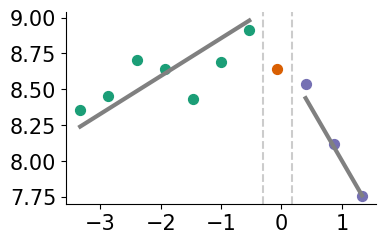

In [53]:
gene_name='SPARC'

if gene_name in discont_genes_layer:
    print(f'gene {gene_name}: discontinuous jump after domain(s) {discont_genes_layer[gene_name]}') 
if gene_name in cont_genes_layer:
    print(f'gene {gene_name}: continuous gradient in domain(s) {cont_genes_layer[gene_name]}')

domain_colors = plt.cm.get_cmap('Dark2', 8).colors  # Returns a tuple of RGBA tuples
domain_colors = list(domain_colors)  # Convert to list if needed

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors,
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)

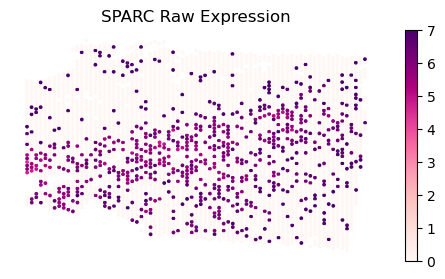

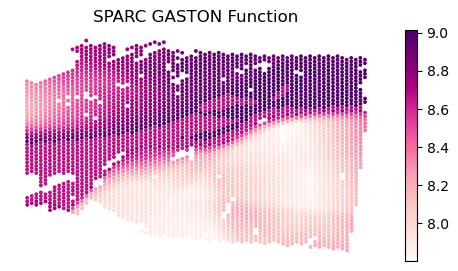

In [54]:
reload(binning_and_plotting)
binning_and_plotting.plot_gene_raw(gene_name, gene_labels_idx, counts_mat, S, vmin=0,vmax=7, 
                                   figsize=(6,3),s=3)
plt.title(f'{gene_name} Raw Expression')
binning_and_plotting.plot_gene_function(gene_name, S, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, figsize=(6,3),s=3)
plt.title(f'{gene_name} GASTON Function')
plt.show()